In [3]:
import numpy as np
import matplotlib.pyplot  as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from keras import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
copypath = '/content/drive/My Drive/data/lightcurve_array.npz'
npz=np.load(copypath)
xdata=npz['lc'][:,:-1] # to make the legth of the two concatenated light curves an even number
ydata=npz['delay']*1e3 # convert to human read units
xdata.shape

(9999, 9998)

In [9]:
xdata = xdata/np.max(xdata,axis=1)[:,np.newaxis]

Delay is 49.97


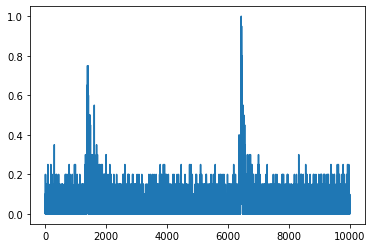

In [10]:
lc0 = xdata[0]
plt.plot(lc0)
print("Delay is {:.2f}".format(ydata[0]))

In [11]:
def ccf(x):
  half = len(x)//2
  a, b = x[0:half], x[half:]
  a = (a - np.mean(a)) / (np.std(a) * len(a))
  b = (b - np.mean(b)) / (np.std(b))
  return np.correlate(a,b,'same')

In [12]:
def ccf_cumsum(x,dd=False):
  half = len(x)//2 
  cs1 = np.cumsum(x[0:half])
  cs2 = np.cumsum(x[half:])
  cs1 /= np.max(cs1)
  cs2 /= np.max(cs2)
  if dd:
    cs1 = np.diff(np.diff(cs1))
    cs2 = np.diff(np.diff(cs2))
  return np.correlate(cs1,cs2,'same')

2448

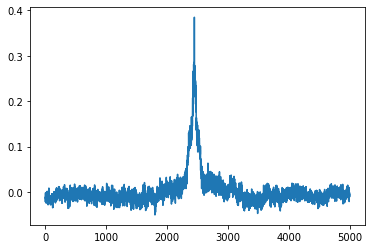

In [13]:
ccf_lc0 = ccf(lc0)
plt.plot(ccf_lc0)
np.argmax(ccf_lc0)

In [14]:
ccfdata = np.apply_along_axis(func1d=ccf, axis=1, arr=xdata)

In [15]:
ccfdata.shape

(9999, 4999)

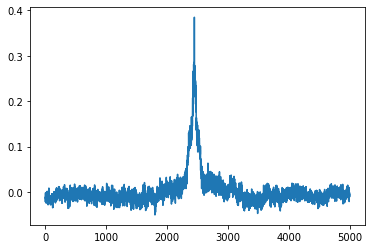

In [16]:
ccfdata_preview =  ccfdata[0]
plt.plot(ccfdata_preview)

Mean = 7.105427e-17, std = 1.000


(9999, 400)

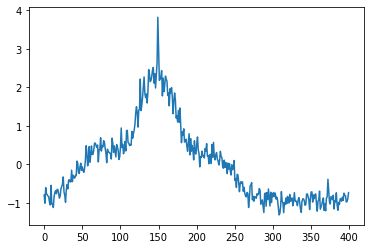

In [36]:
nbins_full = ccfdata.shape[1]
window_size = 400
xtrain = np.copy(ccfdata[:,nbins_full//2-window_size//2:nbins_full//2+window_size//2])
#z = (x - u) / s
xtrain = (xtrain - np.mean(xtrain, axis=1)[:,None])/np.std(xtrain,axis=1)[:,None]
plt.plot(xtrain[0])
print('Mean = {:e}, std = {:.3f}'.format( np.mean(xtrain[0]), np.std(xtrain[0])) )
xtrain.shape

In [18]:
def gprocess(x, downsample=2):
  n = len(x)
  kernel = 1.0*RBF(2.0) + WhiteKernel()
  gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
  X = np.atleast_2d(np.linspace(0,n,n)).T
  y = np.atleast_2d(x).T
  gp.fit(X,y)
  X2 = np.atleast_2d(np.linspace(0, n, downsample*n)).T
  f = gp.predict(X2)
  return f.ravel()

In [23]:
downsample = 4

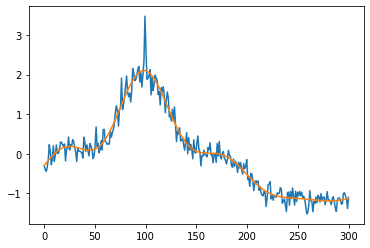

In [19]:
downsample = 4
gp_smooth = gprocess(xtrain[0], downsample=downsample)
n = len(xtrain[0])
plt.plot(np.linspace(0, n, n), xtrain[0])
plt.plot(np.linspace(0, n, downsample*n), gp_smooth)

In [20]:
def generate_smooth_gp(xtrain, downsample=2, verbose=True, save=False, random_state=42):
  Nsamples = xtrain.shape[0]
  n = xtrain.shape[1]
  kernel = 1.0*RBF(2.0) + WhiteKernel()
  gp = GaussianProcessRegressor(kernel=kernel, random_state=random_state)
  X_in = np.atleast_2d(np.linspace(0,n,n)).T
  X_out = np.atleast_2d(np.linspace(0, n, downsample*n)).T
  xtrain_smooth = np.empty((Nsamples, downsample*n))
  print(f'Going to do {Nsamples} fits')
  for i in range(Nsamples):
    y = xtrain[i,:]
    gp.fit(X_in,y)
    if verbose and ((i+1)%25 == 0):
      print('.', end ="")
    if verbose and ((i+1)%1000 == 0):
      print(f'. {i+1} steps')
    xtrain_smooth[i,:] = gp.predict(X_out)
  if save:
    np.savez('/content/drive/My Drive/data/xtrain_smooth%i.npz'%downsample,xtrain_smooth)
  return xtrain_smooth

In [37]:
xtrain_smooth4 = generate_smooth_gp(xtrain, downsample=4, verbose=True, save=True)

Going to do 9999 fits
.......................................Step 1000
........................................Step 2000
........................................Step 3000
........................................Step 4000
........................................Step 5000
........................................Step 6000
........................................Step 7000
........................................Step 8000
........................................Step 9000
........................................

In [ ]:
Nsamples = xtrain.shape[0]
kernel = 1.0*RBF(2.0) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
X = np.atleast_2d(np.linspace(0,n,n)).T
X2 = np.atleast_2d(np.linspace(0, n, downsample*n)).T
xtrain_smooth = np.empty((Nsamples, downsample*n))

In [ ]:
for i in range(Nsamples):
  y = xtrain[i,:]
  gp.fit(X,y)
  if i%1000 == 0:
    print(f'Step {i}')
  if i%50 == 0:
    print('.', end ="")
  xtrain_smooth[i,:] = gp.predict(X2)

Step 0
....................Step 1000
....................Step 2000
....................Step 3000
....................Step 4000
.............

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


.......Step 5000
....................Step 6000
....................Step 7000
....................Step 8000
....................Step 9000
....................

In [ ]:
np.savez('/content/drive/My Drive/data/xtrain_smooth2.npz',xtrain_smooth)

In [25]:
xtrain_smooth = xtrain_smooth4

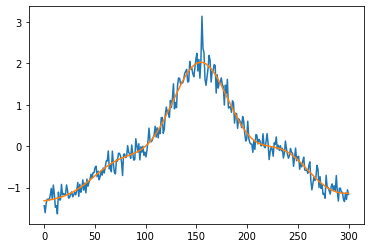

In [24]:
# 4650-4700
i = 4700
plt.plot(np.linspace(0, n, n), xtrain[i])
plt.plot(np.linspace(0, n, downsample*n), xtrain_smooth[i])

In [26]:
xtrain_smooth.shape

(9999, 1200)

In [ ]:
np.savez('/content/drive/My Drive/data/xtrain.npz',xtrain)

In [ ]:
np.savez('/content/drive/My Drive/data/xtrain_smooth.npz',xtrain_smooth)

In [ ]:
# xtrain_smooth = np.apply_along_axis(func1d=gprocess, axis=1, arr=xtrain, downsample=4)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ydata, test_size=0.30, random_state=0)
orig_dim=X_train[0].shape
X_train.shape, y_train.shape, orig_dim

((6999, 300), (6999,), (300,))

In [28]:
model = Sequential() # 48, 24
model.add(Dense(units=32, input_shape=(orig_dim),activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=24,activation='sigmoid'))
model.add(Dense(units=1))
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=m)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                9632      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 10,449
Trainable params: 10,449
Non-trainable params: 0
_________________________________________________________________


In [30]:
nepochs = 100
batch_size = 100
h = model.fit(X_train,y_train,epochs=nepochs,batch_size=batch_size, validation_data=(X_test,y_test), verbose=0)

In [ ]:
# h = estimator.fit(X_train, y_train, validation_data=(X_test,y_test))

In [ ]:
# model.save('/content/drive/My Drive/data/my_ccfmodel')

In [31]:
def accuracy_plot(y_test, y_pred):
  plt.scatter(y_test,y_pred,color="r")
  plt.xlabel("True delay")
  plt.xlabel("ML delay")
  plt.plot([-0.06*1e3,0.06*1e3],[-0.06*1e3,0.06*1e3],':')
  plt.xlim([-0.06*1e3,0.06*1e3])
  plt.ylim([-0.06*1e3,0.06*1e3])

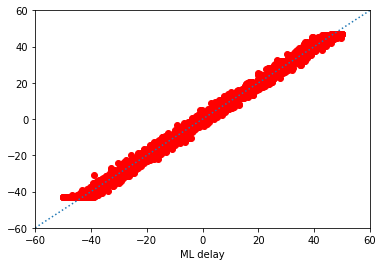

In [32]:
y_pred = model.predict(X_test)
accuracy_plot(y_test, y_pred)

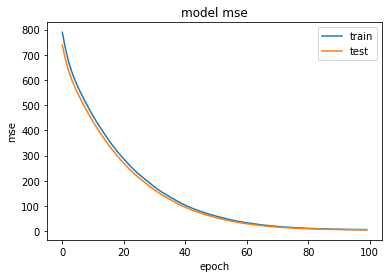

In [33]:
# summarize history for loss
plt.plot(h.history['mean_squared_error'], label='train')
plt.plot(h.history['val_mean_squared_error'], label='test')
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()

In [34]:
def howGoodAmI(y_test, y_pred):
  diff = y_test - y_pred.ravel()
  hist = plt.hist(diff)
  bincentres = (hist[1][:-1]+hist[1][1:])/2.
  weights = hist[0]
  mu = np.average(bincentres,weights=weights)
  sigma = np.average((bincentres-mu)**2, weights=weights)
  return mu, sigma

(-0.11455073120262055, 5.031031688818352)

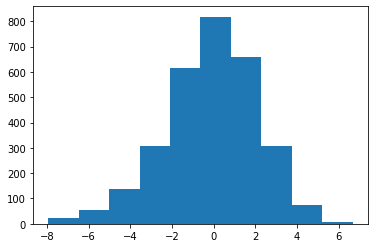

In [35]:
howGoodAmI(y_test, y_pred)

In [ ]:
#scaler = StandardScaler()
#X_train_ = scaler.fit_transform(X_train)
#pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

(-60.0, 60.0)

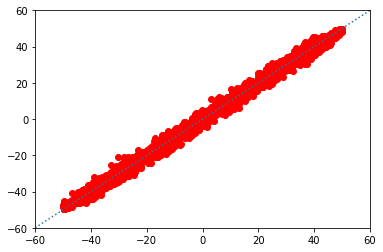

In [ ]:
y_pred = gbr.predict(X_test)
accuracy_plot(y_test, y_pred)

(0.03734270257826624, 4.678597949711111)

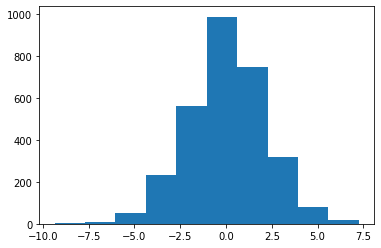

In [ ]:
howGoodAmI(y_test, y_pred)

In [ ]:
len(np.unique(ydata)), len(np.unique(np.around(ydata, decimals=2)))

(9999, 6312)

In [ ]:
ydata[0], np.around(ydata[0], decimals=4)

(0.0499741748906672, 0.05)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xtrain_smooth, ydata, test_size=0.30, random_state=0)
orig_dim=X_train[0].shape
X_train.shape, y_train.shape, orig_dim

((6999, 1000), (6999,), (1000,))

In [ ]:
model = Sequential() # 48, 24
model.add(Dense(units=48, input_shape=(orig_dim),activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=24,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dense(units=1))
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=m)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 48)                48048     
_________________________________________________________________
dropout_15 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 24)                1176      
_________________________________________________________________
dropout_16 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 200       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 49,433
Trainable params: 49,433
Non-trainable params: 0
_________________________________________________

In [ ]:
nepochs = 200
batch_size = 100
h = model.fit(X_train,y_train,epochs=nepochs,batch_size=batch_size, validation_data=(X_test,y_test), verbose=1)

Epoch 1/200
70/70 [==============================] - 0s 4ms/step - loss: 147.1387 - mean_squared_error: 147.1387 - mean_absolute_error: 8.7480 - val_loss: 140.4020 - val_mean_squared_error: 140.4020 - val_mean_absolute_error: 8.2973
Epoch 2/200
70/70 [==============================] - 0s 3ms/step - loss: 144.3067 - mean_squared_error: 144.3067 - mean_absolute_error: 8.6498 - val_loss: 137.7585 - val_mean_squared_error: 137.7585 - val_mean_absolute_error: 8.2250
Epoch 3/200
70/70 [==============================] - 0s 4ms/step - loss: 141.2390 - mean_squared_error: 141.2390 - mean_absolute_error: 8.5228 - val_loss: 134.5869 - val_mean_squared_error: 134.5869 - val_mean_absolute_error: 8.0472
Epoch 4/200
70/70 [==============================] - 0s 4ms/step - loss: 138.5139 - mean_squared_error: 138.5139 - mean_absolute_error: 8.4259 - val_loss: 131.9085 - val_mean_squared_error: 131.9085 - val_mean_absolute_error: 7.9527
Epoch 5/200
70/70 [==============================] - 0s 4ms/step - l

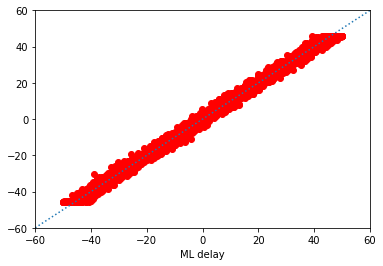

In [ ]:
y_pred = model.predict(X_test)
accuracy_plot(y_test, y_pred)

(-0.06331829850059231, 4.204842504883927)

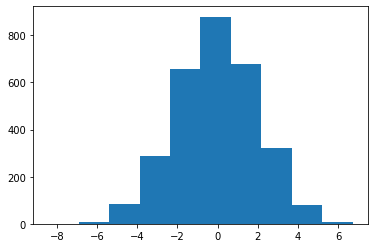

In [ ]:
howGoodAmI(y_test, y_pred)

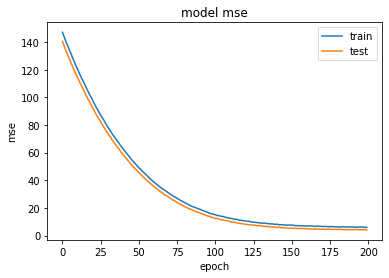

In [ ]:
# summarize history for loss
plt.plot(h.history['mean_squared_error'], label='train')
plt.plot(h.history['val_mean_squared_error'], label='test')
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()

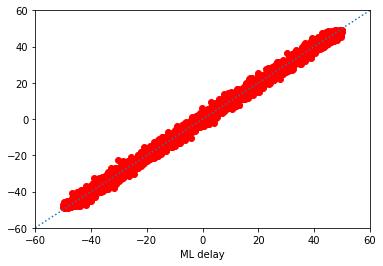

In [ ]:
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
accuracy_plot(y_test, y_pred)

(0.0019478340036920229, 4.046296678118376)

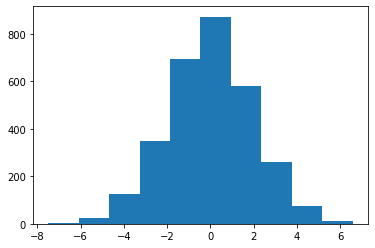

In [ ]:
howGoodAmI(y_test, y_pred)

In [ ]:
xtrain_smooth.shape, ydata.shape

((9999, 1000), (9999,))

In [ ]:
i = 1400
model.predict(np.atleast_2d(xtrain_smooth[i,:])), ydata[i]

(array([[-45.570267]], dtype=float32), -46.11518715973944)

In [ ]:
error = 0.05
data = np.copy(xtrain_smooth)
sim_xdata = data + error*np.random.normal(size=data.shape)

In [ ]:
sim_xdata.shape

(9999, 1000)

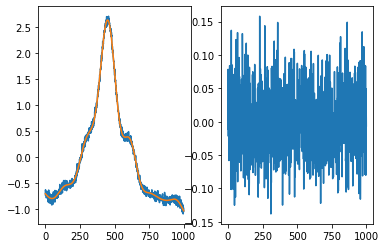

In [ ]:
i = 10
plt.subplot(121)
plt.plot(sim_xdata[i])
plt.plot(data[i])
plt.subplot(122)
plt.plot(sim_xdata[i]-data[i])

In [ ]:
xtrain_combined = np.concatenate([xtrain_smooth, sim_xdata])
ydata_combined = np.concatenate([ydata, ydata])
xtrain_combined.shape, ydata_combined.shape

((19998, 1000), (19998,))

In [ ]:
ind_arr = np.arange(xtrain_combined.shape[0])
np.random.shuffle(ind_arr)

In [ ]:
xtrain_combined = xtrain_combined[ind_arr,:]
ydata_combined = ydata_combined[ind_arr]
xtrain_combined.shape, ydata_combined.shape, 

((19998, 1000), (19998,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xtrain_combined, ydata_combined, test_size=0.30, random_state=0)
orig_dim=X_train[0].shape
X_train.shape, y_train.shape, orig_dim

((13998, 1000), (13998,), (1000,))

In [ ]:
model = Sequential() # 48, 24
model.add(Dense(units=48, input_shape=(orig_dim),activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=24,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dense(units=1))
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=m)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 48)                48048     
_________________________________________________________________
dropout_21 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 24)                1176      
_________________________________________________________________
dropout_22 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 8)                 200       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 9         
Total params: 49,433
Trainable params: 49,433
Non-trainable params: 0
_________________________________________________

In [ ]:
nepochs = 200
batch_size = 100
h = model.fit(X_train,y_train,epochs=nepochs,batch_size=batch_size, validation_data=(X_test,y_test), verbose=1)

Epoch 1/200
140/140 [==============================] - 1s 5ms/step - loss: 805.4418 - mean_squared_error: 805.4418 - mean_absolute_error: 24.4288 - val_loss: 778.8177 - val_mean_squared_error: 778.8177 - val_mean_absolute_error: 23.9300
Epoch 2/200
140/140 [==============================] - 1s 4ms/step - loss: 764.1295 - mean_squared_error: 764.1295 - mean_absolute_error: 23.6108 - val_loss: 743.4106 - val_mean_squared_error: 743.4106 - val_mean_absolute_error: 23.2145
Epoch 3/200
140/140 [==============================] - 0s 3ms/step - loss: 733.8126 - mean_squared_error: 733.8126 - mean_absolute_error: 22.9944 - val_loss: 717.4524 - val_mean_squared_error: 717.4524 - val_mean_absolute_error: 22.6831
Epoch 4/200
140/140 [==============================] - 0s 3ms/step - loss: 710.1080 - mean_squared_error: 710.1080 - mean_absolute_error: 22.5079 - val_loss: 695.5944 - val_mean_squared_error: 695.5944 - val_mean_absolute_error: 22.2359
Epoch 5/200
140/140 [==============================]

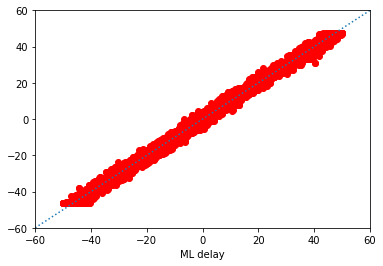

In [ ]:
y_pred = model.predict(X_test)
accuracy_plot(y_test, y_pred)

(0.04678002304841593, 3.944743361785659)

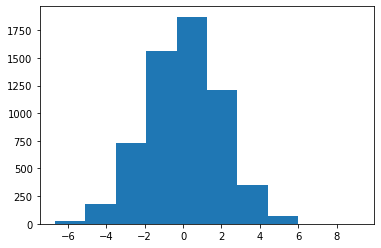

In [ ]:
howGoodAmI(y_test, y_pred)

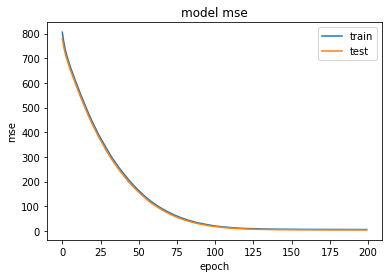

In [ ]:
# summarize history for loss
plt.plot(h.history['mean_squared_error'], label='train')
plt.plot(h.history['val_mean_squared_error'], label='test')
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()